## Recommender System

#### load data

In [1]:
from pyspark.sql import SparkSession
from pyspark.sql import functions as F
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
spark = SparkSession.builder.appName('YelpRec').getOrCreate()
conf = spark.sparkContext._conf.setAll([('spark.executor.memory', '5g'), ('spark.app.name', 'Spark Updated Conf'), ('spark.executor.cores', '4'), ('spark.cores.max', '4'), ('spark.driver.memory','8g')])


In [247]:
dataDir = "gs://msca-bdp-student-gcs/group2/yelp-kaggleAPI"
business = spark.read.json(dataDir + "/yelp_academic_dataset_business.json")
#checkin = spark.read.json(dataDir + "/sample_checkin")
review = spark.read.json(dataDir + "/yelp_academic_dataset_review.json")
#tip = spark.read.json(dataDir + "/sample_tip")
#user = spark.read.json(dataDir + "/sample_user")

In [248]:
business.show(5)

+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|             address|          attributes|         business_id|          categories|         city|               hours|is_open|  latitude|   longitude|                name|postal_code|review_count|stars|state|
+--------------------+--------------------+--------------------+--------------------+-------------+--------------------+-------+----------+------------+--------------------+-----------+------------+-----+-----+
|1616 Chapala St, ...|{null, null, null...|Pns2l4eNsfO8kk83d...|Doctors, Traditio...|Santa Barbara|                null|      0|34.4266787|-119.7111968|Abby Rappoport, L...|      93101|           7|  5.0|   CA|
|87 Grasso Plaza S...|{null, null, null...|mpf3x-BjTdTEA3yCZ...|Shipping Centers,...|       Affton|{8:0-18:30, 0:0-0...|      1| 38.551126|  -90.335695|    

In [249]:
business.take(1)

[Row(address='1616 Chapala St, Ste 2', attributes=Row(AcceptsInsurance=None, AgesAllowed=None, Alcohol=None, Ambience=None, BYOB=None, BYOBCorkage=None, BestNights=None, BikeParking=None, BusinessAcceptsBitcoin=None, BusinessAcceptsCreditCards=None, BusinessParking=None, ByAppointmentOnly='True', Caters=None, CoatCheck=None, Corkage=None, DietaryRestrictions=None, DogsAllowed=None, DriveThru=None, GoodForDancing=None, GoodForKids=None, GoodForMeal=None, HairSpecializesIn=None, HappyHour=None, HasTV=None, Music=None, NoiseLevel=None, Open24Hours=None, OutdoorSeating=None, RestaurantsAttire=None, RestaurantsCounterService=None, RestaurantsDelivery=None, RestaurantsGoodForGroups=None, RestaurantsPriceRange2=None, RestaurantsReservations=None, RestaurantsTableService=None, RestaurantsTakeOut=None, Smoking=None, WheelchairAccessible=None, WiFi=None), business_id='Pns2l4eNsfO8kk83dixA6A', categories='Doctors, Traditional Chinese Medicine, Naturopathic/Holistic, Acupuncture, Health & Medical,

In [250]:
business.printSchema()

root
 |-- address: string (nullable = true)
 |-- attributes: struct (nullable = true)
 |    |-- AcceptsInsurance: string (nullable = true)
 |    |-- AgesAllowed: string (nullable = true)
 |    |-- Alcohol: string (nullable = true)
 |    |-- Ambience: string (nullable = true)
 |    |-- BYOB: string (nullable = true)
 |    |-- BYOBCorkage: string (nullable = true)
 |    |-- BestNights: string (nullable = true)
 |    |-- BikeParking: string (nullable = true)
 |    |-- BusinessAcceptsBitcoin: string (nullable = true)
 |    |-- BusinessAcceptsCreditCards: string (nullable = true)
 |    |-- BusinessParking: string (nullable = true)
 |    |-- ByAppointmentOnly: string (nullable = true)
 |    |-- Caters: string (nullable = true)
 |    |-- CoatCheck: string (nullable = true)
 |    |-- Corkage: string (nullable = true)
 |    |-- DietaryRestrictions: string (nullable = true)
 |    |-- DogsAllowed: string (nullable = true)
 |    |-- DriveThru: string (nullable = true)
 |    |-- GoodForDancing: str

In [252]:
#business.count()

### Recommendation system - ALS

In [253]:
from pyspark import SparkContext
from pyspark.ml.recommendation import ALS
from pyspark.sql import Row
from pyspark.sql.functions import col
from pyspark.sql import SQLContext
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.sql.types import StructType,StructField,IntegerType
import matplotlib.pyplot as plt
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder, TrainValidationSplit
%matplotlib inline

In [258]:
df_business = business.select("business_id","name", "stars", 
                                 "review_count", "attributes", 
                                 "categories", "city").withColumnRenamed("stars", "stars_restaurant")

#df_business = df_business.filter((df_business['city'] == 'Toronto') & (df_business.categories.contains('Restaurants'))).drop('city')
df_business = df_business.filter(df_business.categories.contains('Restaurants')).drop('city')

In [259]:
# join review table and business table
df_review = review.join(df_business, on='business_id', how='inner')

In [260]:
df_review = df_review.select(['business_id', 'user_id', 'stars'])

In [261]:
df_review.show(5)

+--------------------+--------------------+-----+
|         business_id|             user_id|stars|
+--------------------+--------------------+-----+
|XQfwVwDr-v0ZS3_Cb...|mh_-eMZ6K5RLWhZyI...|  3.0|
|YjUWPpI6HXG530lwP...|8g_iMtfSiwikVnbP2...|  3.0|
|kxX2SOes4o-D3ZQBk...|_7bHUi9Uuf5__HHc_...|  5.0|
|e4Vwtrqf-wpJfwesg...|bcjbaE6dDog4jkNY9...|  4.0|
|04UD14gamNjLY0IDY...|eUta8W_HdHMXPzLBB...|  1.0|
+--------------------+--------------------+-----+
only showing top 5 rows



In [262]:
df_review.printSchema()

root
 |-- business_id: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- stars: double (nullable = true)



In [263]:
# convert complex ids to numbers
indexer = [StringIndexer(inputCol=column, outputCol=column+"_index") for column in ['business_id', 'user_id']]
pipeline = Pipeline(stages=indexer)
df_review = pipeline.fit(df_review).transform(df_review)
df_review.show(5)

23/08/14 05:01:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB


+--------------------+--------------------+-----+-----------------+-------------+
|         business_id|             user_id|stars|business_id_index|user_id_index|
+--------------------+--------------------+-----+-----------------+-------------+
|XQfwVwDr-v0ZS3_Cb...|mh_-eMZ6K5RLWhZyI...|  3.0|           6718.0|      24209.0|
|YjUWPpI6HXG530lwP...|8g_iMtfSiwikVnbP2...|  3.0|          21453.0|      15733.0|
|kxX2SOes4o-D3ZQBk...|_7bHUi9Uuf5__HHc_...|  5.0|           6107.0|     232143.0|
|e4Vwtrqf-wpJfwesg...|bcjbaE6dDog4jkNY9...|  4.0|          25997.0|       2380.0|
|04UD14gamNjLY0IDY...|eUta8W_HdHMXPzLBB...|  1.0|           3481.0|    1164597.0|
+--------------------+--------------------+-----+-----------------+-------------+
only showing top 5 rows



In [264]:
#average_stars_df = df_review.groupBy("business_id", "user_id").agg(F.avg("stars").alias("average_stars"))
#average_stars_df.show(5)

In [265]:
#df_review.printSchema()

In [266]:
# repartition data
df_review.rdd.getNumPartitions()

40

In [19]:
df_review = df_review.repartition(16)

In [20]:
df_review.show(3)

23/08/13 23:02:58 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1945.9 KiB


+--------------------+--------------------+-----+-----------------+-------------+
|         business_id|             user_id|stars|business_id_index|user_id_index|
+--------------------+--------------------+-----+-----------------+-------------+
|898K8ftMbdWe2Dc67...|QTXN3eKNhd2fl8QDR...|  5.0|            173.0|      19276.0|
|DW9rgqWWzidDLIazm...|x5yhn06D-_9yTVjUq...|  5.0|            720.0|      38399.0|
|eQPX1bLy7UA7aFvZH...|5B2kbyk3so9QST_mJ...|  3.0|            414.0|       6972.0|
+--------------------+--------------------+-----+-----------------+-------------+
only showing top 3 rows



In [267]:
(training, test) = df_review.randomSplit([0.8, 0.2])

In [268]:
training.count()

23/08/14 05:02:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB


3779582

In [269]:
test.count()

23/08/14 05:05:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB


944889

In [ ]:
als=ALS(maxIter=5,
        regParam=0.09,
        rank=10,
        #numUserBlocks: 6, numItemBlocks = 6,
        userCol="user_id_index",
        itemCol="business_id_index",
        ratingCol="stars",
        coldStartStrategy="drop",  #drop any rows in the DataFrame of predictions that contain NaN values
        nonnegative=True)

model=als.fit(training)

23/08/14 05:06:33 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:06:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:12 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:34 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:40 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:07:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task 

In [271]:
evaluator = RegressionEvaluator(metricName="rmse",labelCol="stars",predictionCol="prediction")

In [272]:
predictions = model.transform(test)
rmse = evaluator.evaluate(predictions)
print("RMSE="+str(rmse))

23/08/14 05:09:22 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:09:24 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:09:30 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 60.9 MiB
23/08/14 05:10:07 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 61.0 MiB
23/08/14 05:10:20 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 61.0 MiB


RMSE=1.5241776488783785


### 1. Get top 10 restaurants recommendation for a specific user

In [273]:
# recommend for a random user
#users = df_review.select(als.getUserCol()).distinct().limit(1)
#userSubsetRecs = model.recommendForUserSubset(users, 10).select('user_id_index','recommendations')

#userSubsetRecs.show(10, truncate=False)

In [274]:
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import re

def categories_wordcloud(table, exclude_words=None):
    res_categories = table.select('categories').collect()
    res_categories = [res_categories[i][0] for i in range(len(res_categories))]
    text = " ".join(i for i in res_categories)

    # Exclude unnecessary text
    if exclude_words:
        exclude_pattern = '|'.join(exclude_words)
        text = re.sub(exclude_pattern, '', text)
    
    # Generate a word cloud image
    wordcloud = WordCloud(background_color="white").generate(text)

    plt.figure(figsize=(10,8))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis("off")
    plt.show()

In [275]:
def rec_for_user(user_id_index,exclude_words):
    userSubsetRecs = model.recommendForAllUsers(10).filter(col('user_id_index')==user_id_index).select("recommendations").collect()
    
    topRes = []
    for item in userSubsetRecs[0][0]:        
        topRes.append(item.business_id_index)

    schema = StructType([StructField("business_id_index",IntegerType(),True)])
    res = spark.createDataFrame(topRes,IntegerType()).toDF("business_id_index")
    
    res = res.join(df_review, on = 'business_id_index', how = 'inner').select(['business_id'])
    res.dropDuplicates().show()
    res = res.join(df_business, on = 'business_id', how = 'inner').select(['business_id','name','categories'])
    res = res.dropDuplicates(subset=['business_id'])
    res.show(truncate=False)
    
    categories_wordcloud(res, exclude_words)

#### **For user_id_index = 30:**

23/08/14 05:16:57 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 61.0 MiB
23/08/14 05:26:38 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 61.0 MiB
23/08/14 05:26:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:26:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:26:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:26:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:26:51 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+--------------------+
|         business_id|
+--------------------+
|8jkCh4MKxS126H-ld...|
|icJ0Ux9mxjKpzAJdX...|
|wvqIG-nWucD9ML2Pt...|
|Rg4TiemxYLiYm61Ur...|
|nKns5yMGiTpYY45Sl...|
|Q1-j1Bx66IPzs1fbC...|
|vsNocE3RodCulWVmg...|
|m2eHKE6wcmYhZysdy...|
|qiHFB9B4ZI4uA54Ym...|
|J46HWg-cdKhAhncLt...|
+--------------------+



23/08/14 05:26:52 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:27:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:27:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:27:00 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:27:01 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB


+----------------------+-------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|business_id           |name                     |categories                                                                                                                                     |
+----------------------+-------------------------+-----------------------------------------------------------------------------------------------------------------------------------------------+
|8jkCh4MKxS126H-ld-AFYw|Cafe Adriatic            |Ice Cream & Frozen Yogurt, Coffee & Tea, Sandwiches, Cafes, Restaurants, Food, Juice Bars & Smoothies                                          |
|icJ0Ux9mxjKpzAJdXm67GA|Deli-Grove               |Cheesesteaks, Delis, Sandwiches, Restaurants                                                                                                   |
|wvqIG-nWucD9ML2Pt7BdVQ|L

23/08/14 05:27:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:27:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB
23/08/14 05:27:10 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.6 MiB


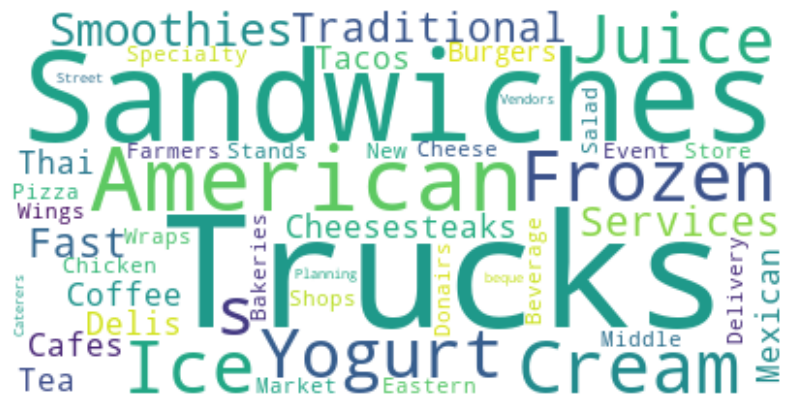

In [276]:
rec_for_user(30,exclude_words=['Restaurants', 'Food', 'Bar'])

In [277]:
# write a function to get past visits of the user. 

def user_past_visits(user_id_index, exclude_words):
    past_res = df_review.filter(df_review.user_id_index == user_id_index).select('business_id')
    past_res = past_res.join(df_business, on = 'business_id', how = 'inner').select(['business_id','name','categories'])
    past_res = past_res.dropDuplicates(subset=['business_id'])
    past_res.show(truncate=False)
    
    categories_wordcloud(past_res, exclude_words)

23/08/14 05:27:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 05:28:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB


+----------------------+----------------------------+---------------------------------------------------------------------------------------------------------------------+
|business_id           |name                        |categories                                                                                                           |
+----------------------+----------------------------+---------------------------------------------------------------------------------------------------------------------+
|-Uzw3Hvy1KBNxak9vWsYyQ|Riverwinds Restaurant       |Seafood, American (New), Steakhouses, Restaurants                                                                    |
|-ZzCVD9Ge7KCy4ffhYkGZQ|Richman's Ice Cream & Burger|Restaurants, Food, Ice Cream & Frozen Yogurt, Burgers                                                                |
|-cEFKAznWmI0cledNOIQ7w|Gran Caffe L'Aquila         |Restaurants, Gelato, Coffee & Tea, Food, Italian, Bakeries                             

23/08/14 05:28:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 05:28:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB


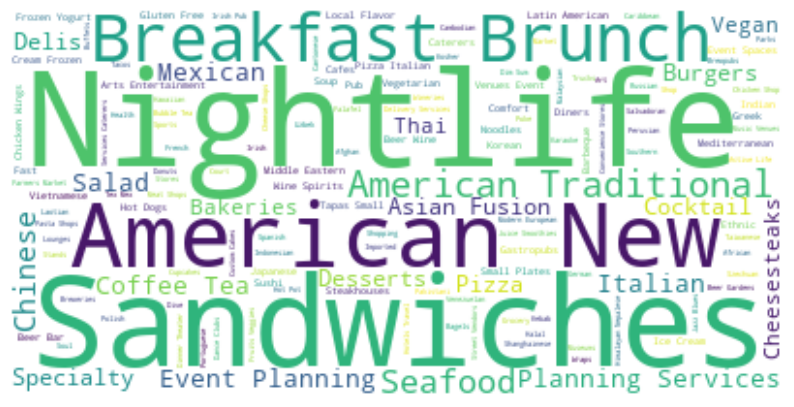

In [278]:
user_past_visits(30, exclude_words =['Restaurants', 'Food', 'Bars'])

### 2. Get top 10 user recommendation for a specific restaurant

In [279]:
def rec_for_res(business_id_index,exclude_words):
    resSubsetRecs = model.recommendForAllItems(10).filter(col('business_id_index')==business_id_index).select("recommendations").collect()
    
    topRes = []
    for item in resSubsetRecs[0][0]:        
        topRes.append(item.user_id_index)

    schema = StructType([StructField("user_id_index",IntegerType(),True)])
    user = spark.createDataFrame(topRes,IntegerType()).toDF("user_id_index")
    user_past = user.join(df_review, on = 'user_id_index', how = 'inner').select('user_id','business_id')
    
    print('Past places Top 10 users have been to:')
    user_past.dropDuplicates(subset=['business_id', 'user_id']).show()
    user_past = user_past.join(df_business, on = 'business_id', how = 'inner').select(['business_id','name','categories'])
    user_past = user_past.dropDuplicates(subset=['business_id'])
    user_past.show(truncate=False)
    
    print('Categories of restaurants Top 10 users have been to:')
    categories_wordcloud(user_past, exclude_words)

23/08/14 05:55:11 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 61.0 MiB
23/08/14 06:03:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 61.0 MiB


Past places Top 10 users have been to:


23/08/14 06:03:09 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:03:28 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:03:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:03:47 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:03:50 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB


+--------------------+--------------------+
|             user_id|         business_id|
+--------------------+--------------------+
|1aaXBiPuYX2t-h8kq...|-lX4ufgPLYubI8rVx...|
|9YhGeA9Q_quwAylLg...|592HGLvTk4gaoH5BE...|
|X3fYkqlfQFNI3vP2s...|DQgX6IbCPg3SKdFAg...|
|ezWl6sN9YnVY2STyE...|zljfjg_zTL3ceGi_V...|
|u51c7q-U7gdLivK3T...|XTHUxyHgR7WEfdXgZ...|
|X3fYkqlfQFNI3vP2s...|l_slvEnh4v3W8BXF1...|
|9YhGeA9Q_quwAylLg...|t0FzBzAoqVpK5fNIG...|
|u51c7q-U7gdLivK3T...|ve_-rPlEGPClytyJt...|
|u51c7q-U7gdLivK3T...|w18LqIckdMOK7-PU4...|
|5PAeKyyQdDbb5Isdx...|_ab50qdWOk0DdB6XO...|
|cvysoMavGK63YjA-_...|3WU1ZobAqXQ07xYoK...|
|u51c7q-U7gdLivK3T...|UBIG1I0th2sSLekfX...|
|5PAeKyyQdDbb5Isdx...|6a4gLLFSgr-Q6CZXD...|
|5PAeKyyQdDbb5Isdx...|OINbC0rpDVJ5bfxt3...|
|nL2lffTJH_wCet9kU...|NtglwXi9aLXenlprL...|
|9YhGeA9Q_quwAylLg...|I8KMfyZoEqzLQtChv...|
|5PAeKyyQdDbb5Isdx...|Bj7DL3SwmYHZYqPdu...|
|5PAeKyyQdDbb5Isdx...|sG-Z7aIlkmKW7EstH...|
|1aaXBiPuYX2t-h8kq...|8BhNur6_XKLjCDvbh...|
|Enunugs-APvGVykdb...|KC8_Rx4Orl

23/08/14 06:04:04 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:04:21 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:04:29 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:04:32 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:04:36 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB


+----------------------+-----------------------------------------------------+------------------------------------------------------------------------------------------------------------+
|business_id           |name                                                 |categories                                                                                                  |
+----------------------+-----------------------------------------------------+------------------------------------------------------------------------------------------------------------+
|XTHUxyHgR7WEfdXgZIh3bA|Port of Subs                                         |Delis, Caterers, Event Planning & Services, Sandwiches, Restaurants                                         |
|5B-m3Nir02zheQnEGopV0w|Killer Shrimp                                        |Restaurants, Music Venues, American (New), Arts & Entertainment, Nightlife, Seafood, Steakhouses            |
|NtglwXi9aLXenlprL49MjQ|Pizza Hut                           

23/08/14 06:04:45 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:05:02 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB
23/08/14 06:05:13 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 58.3 MiB


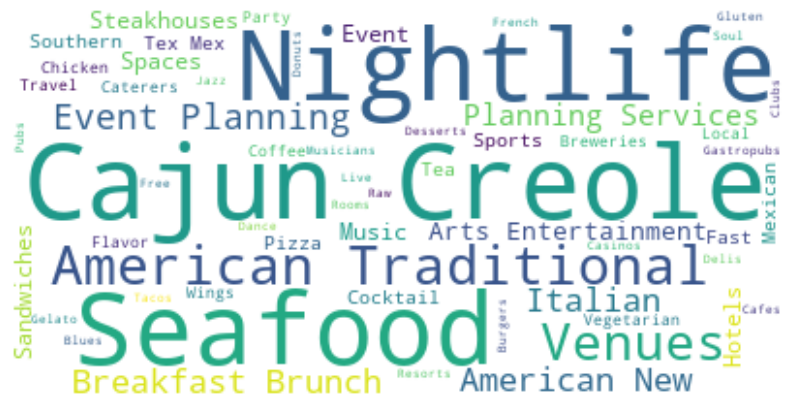

In [280]:
rec_for_res(25,exclude_words =['Restaurants', 'Food', 'Bars'])

In [286]:
def get_restaurants_categories(business_id_index):
    
    res = df_review.filter(df_review.business_id_index == business_id_index).select('business_id').drop_duplicates()    
    res = res.join(df_business, on = 'business_id', how = 'inner').select(['business_id','name','categories']).drop_duplicates()    
    res.show(truncate=False)

In [289]:
#df_review.take(1)

In [290]:
#get_restaurants_categories(25)

## Hyperparameter tuning

In [145]:
#initialize ALS model
als_model = ALS(userCol='user_id_index', itemCol='business_id_index', ratingCol='stars', coldStartStrategy='drop')

# create parameter grid
params = ParamGridBuilder().addGrid(als_model.regParam, [0.01, 0.05, 0.1])\
                            .addGrid(als_model.rank, [10, 15, 20])\
                            .build()

In [146]:
params

[{Param(parent='ALS_af1c156e6458', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='ALS_af1c156e6458', name='rank', doc='rank of the factorization'): 10},
 {Param(parent='ALS_af1c156e6458', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='ALS_af1c156e6458', name='rank', doc='rank of the factorization'): 15},
 {Param(parent='ALS_af1c156e6458', name='regParam', doc='regularization parameter (>= 0).'): 0.01,
  Param(parent='ALS_af1c156e6458', name='rank', doc='rank of the factorization'): 20},
 {Param(parent='ALS_af1c156e6458', name='regParam', doc='regularization parameter (>= 0).'): 0.05,
  Param(parent='ALS_af1c156e6458', name='rank', doc='rank of the factorization'): 10},
 {Param(parent='ALS_af1c156e6458', name='regParam', doc='regularization parameter (>= 0).'): 0.05,
  Param(parent='ALS_af1c156e6458', name='rank', doc='rank of the factorization'): 15},
 {Param(parent='ALS_af1c156e6458', name='regParam', doc='regularizatio

In [147]:
## crossvalidator estimator
evaluator = RegressionEvaluator(metricName='rmse', labelCol='stars', predictionCol='prediction') #same as before

cv = CrossValidator(estimator=als_model, estimatorParamMaps = params, evaluator = evaluator, parallelism = 4)

tuning_models = cv.fit(training)

best_model = tuning_models.bestModel

23/08/14 02:47:46 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1945.9 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2004.0 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2004.0 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2004.0 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2004.0 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2005.8 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2005.8 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2005.8 KiB
23/08/14 02:47:48 WARN org.apache.spark.scheduler.DAGScheduler: Broadcas

In [148]:
best_params = best_model.extractParamMap()
for param, value in best_params.items():
    print(f"{param.name}: {value}")

blockSize: 4096
predictionCol: prediction
coldStartStrategy: drop
itemCol: business_id_index
userCol: user_id_index


In [149]:
best_model.rank

20

In [150]:
best_predictions = best_model.transform(test)
best_rmse = evaluator.evaluate(best_predictions)
print("Best RMSE="+str(best_rmse))

23/08/14 02:50:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2037.3 KiB
23/08/14 02:50:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2035.9 KiB
23/08/14 02:50:41 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 1945.9 KiB
23/08/14 02:50:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


Best RMSE=3.9316769317553235


23/08/14 02:50:43 WARN org.apache.spark.scheduler.DAGScheduler: Broadcasting large task binary with size 2.0 MiB


The RMSE is larger than our current best model after hyperparameter tuning. It is probably because of overfitting. 